In [51]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


In [52]:

#import surface file, such as lh.pial or lh.white
#this is an example I can use

vertices, faces = nib.freesurfer.read_geometry("bert/surf/lh.pial")
print(vertices.shape)

annot = nib.freesurfer.io.read_annot("bert/label/lh.aparc.annot",orig_ids = False)
#axis 0 contains the labels no.
#axis 1 contains the coordinates
#axis 2 contains the label name (str)

label= annot[0]
ctab= annot[1]
name = (annot[2])
for i in range(len(name)):
    name[i]= name[i].decode(encoding="utf-8", errors="strict")

print(label, name)

(134814, 3)
[11 11 11 ... 28  2 30] ['unknown', 'bankssts', 'caudalanteriorcingulate', 'caudalmiddlefrontal', 'corpuscallosum', 'cuneus', 'entorhinal', 'fusiform', 'inferiorparietal', 'inferiortemporal', 'isthmuscingulate', 'lateraloccipital', 'lateralorbitofrontal', 'lingual', 'medialorbitofrontal', 'middletemporal', 'parahippocampal', 'paracentral', 'parsopercularis', 'parsorbitalis', 'parstriangularis', 'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', 'precuneus', 'rostralanteriorcingulate', 'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal', 'supramarginal', 'frontalpole', 'temporalpole', 'transversetemporal', 'insula']


In [53]:

#just making sure the file is not corrupted 
print(len(label),len(vertices), len(ctab))
print(np.any(vertices))
if np.any(vertices)== True:
    print("File fine")
else:
    print("no vertices found ")


134814 134814 36
True
File fine


In [54]:
#enter ROI label number, refer to the DK_atlas_ref text 
# note that the corpus callosum (4), contains no data
ROI_label= 34
ROI_name= name[ROI_label]

ROI= np.where(label==ROI_label)[0]
print (ROI, ROI_name)

#extract the vertices of the ROI
ROI_vertices=vertices[ROI]


[ 47841  47847  47848  47859  47860  47873  47874  47875  47889  47890
  47891  47903  48716  48724  48725  48726  48737  48738  48739  48748
  48749  48758  48759  48765  48766  48771  48772  49565  49566  49567
  49568  49569  49578  49579  49580  49581  49582  49590  49591  49600
  49601  49602  49610  49611  49612  49619  49620  49627  49628  49637
  50375  50376  50377  50378  50388  50389  50390  50391  50392  50393
  50394  50400  50401  50402  50403  50410  50411  50412  50419  50420
  50426  50427  50428  50435  50443  50444  50453  51293  51294  51295
  51302  51303  51304  51305  51311  51312  51313  51314  51315  51316
  51324  51325  51326  51327  51328  51336  51337  51338  51345  51346
  51347  51353  51354  51355  51364  51365  51372  52150  52151  52158
  52159  52160  52161  52162  52171  52172  52173  52174  52175  52176
  52183  52184  52185  52186  52187  52188  52189  52197  52198  52199
  52200  52208  52209  52210  52217  52218  52219  52228  52229  52230
  5224

In [55]:
# counting regular voxels that contain data, to ensure it contains a volume
# this gives us the same number of voxels as size-1 boxes
# a for loop is slightly inneficient, but gets the job done for smaller ROI

counter= 0

for i in ROI_vertices:
    counter += 1

print(ROI_vertices.shape)
print (counter)


(730, 3)
730


In [56]:
x_min = int(np.min(ROI_vertices[:,0]))
x_max = int(np.max(ROI_vertices[:,0])) +1
y_min = int(np.min(ROI_vertices[:,1]))
y_max = int(np.max(ROI_vertices[:,1])) +1
z_min = int(np.min(ROI_vertices[:,2])) 
z_max = int(np.max(ROI_vertices[:,2])) +1


def box_counting(box_size):
    x_pos= np.arange(x_min, x_max, box_size)
    y_pos = np.arange(y_min, y_max, box_size)
    z_pos= np.arange(z_min, z_max, box_size)
    counter=0
    for x in x_pos:
        for y in y_pos:
            for z in z_pos:
                cube = ((ROI_vertices[:,0]>= x) & (ROI_vertices[:,0]< x+box_size) & (ROI_vertices[:,1]>= y) & (ROI_vertices[:,1]< y+box_size) & (ROI_vertices[:,2]>= z) & (ROI_vertices [:,2]< z+box_size))
                if np.any(cube):
                    counter+=1


    return counter



In [ ]:
#calculates from box sizes of factors of 240
x= np.zeros(18)
y= np.zeros(18)
idx=0
for i in range(2,240):
    if 240 % i == 0:
        number_of_boxes = box_counting(i)
        box_size = i
        # x is the x axis of our graph, representing box size
        x[idx] = int(box_size)
        y[idx]= int(number_of_boxes)
        idx += 1
x = x.astype(int)
y = y.astype(int)   
y=y[0:idx]
x=x[0:idx]


In [ ]:
#calculates from box sizes of factors of 256
y = np.zeros(40)
x=np.zeros(40)
idx = 0
#for i in range(padded_shape):
for i in range(1,11):
        box_size=int(2**i)
        num_box= box_counting(box_size)
        y[idx]= num_box
        x[idx]= box_size
        idx += 1
x = x.astype(int)
y = y.astype(int)   
y=y[0:idx]
x=x[0:idx]

#ultimately, I used factors of 240

In [59]:
print(x, y)


[   2    4    8   16   32   64  128  256  512 1024] [191  58  18   3   1   1   1   1   1   1]


In [60]:
log_x= np.log(x)
log_y=np.log(y)
print(log_x)
print(log_y)

[0.69314718 1.38629436 2.07944154 2.77258872 3.4657359  4.15888308
 4.85203026 5.54517744 6.23832463 6.93147181]
[5.25227343 4.06044301 2.89037176 1.09861229 0.         0.
 0.         0.         0.         0.        ]


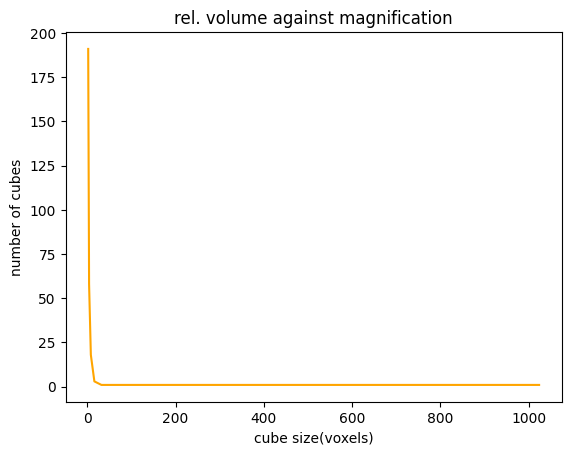

In [61]:



plt.plot(x,y,color='orange')
plt.title('rel. volume against magnification')
plt.xlabel("cube size(voxels)")
plt.ylabel('number of cubes')
plt.show()


In [ ]:
#finding the "ideal" fractal dimension range, systematically
# selects the widest range with a minimum of 4 box sizes for which the r2 > 0.99

widest_range = 0 
best_fd = 0
best_r2= 0
stdev_fd= 0
fd_array = np.array([0])
for j in range(0,idx+1):
    for k in range(1,idx+1):
        if k>j:
            rf_log_x = log_x[j:k]
            rf_log_y = log_y[j:k]
            m, c = np.polyfit(rf_log_x, rf_log_y, 1)
            fd = -m
            correlation_coefficient = np.corrcoef(rf_log_x, rf_log_y)[0,1]
            r2 = correlation_coefficient**2
            if  0.995 < r2 < 1:
                if  k-j >= widest_range:
                    widest_range = k - j
                    min_j = j
                    max_k = k-1
                    best_fd = fd
                    best_r2 = r2    
                    fd_array = np.append(fd_array, fd)
    stdev= np.std(fd_array)

/Users/ro/anaconda_projects/FD_of_the_brain/myenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ro/anaconda_projects/FD_of_the_brain/myenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/sw/s35h26l544q5jxdtmw_32ysw0000gn/T/ipykernel_42383/1435148726.py:14: RankWarning: Polyfit may be poorly conditioned
  m, c = np.polyfit(rf_log_x, rf_log_y, 1)
/Users/ro/anaconda_projects/FD_of_the_brain/myenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/ro/anaconda_projects/FD_of_the_brain/myenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/ro/anaconda_projects/FD_of_

In [63]:
print("the best estimate fractal dimension is: ", best_fd)
print("with R-squared value: ", best_r2, "and standard dev:", stdev)
print( "ideal range is box sizes", x[min_j], "to", x[max_k])
if widest_range<4:
    print('warning: range too small, proceed with caution')
#keep in mind this does not consider multi- or bi-fractals (yet), so the FD with the highest r2 will be chosen

the best estimate fractal dimension is:  1.7037519132967167
with R-squared value:  0.9999717103693411 and standard dev: 0.8518759566483584
ideal range is box sizes 2 to 8


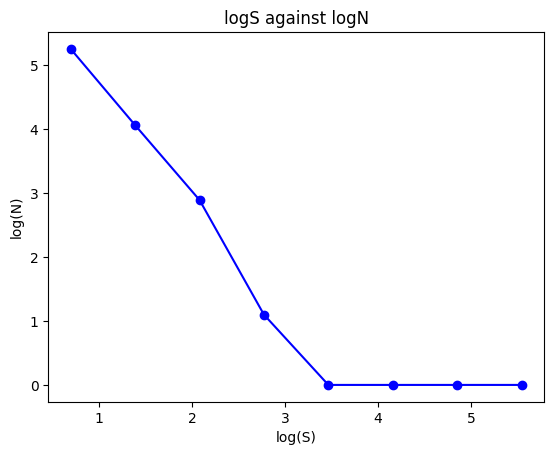

In [ ]:
#use this to explore how the log-log graph changes at different ranges, with a line of best fit!
rf_log_x = log_x[0:8]
rf_log_y = log_y[0:8]
plt.plot(rf_log_x,rf_log_y,color='blue',marker='o')
plt.title('logS against logN')
plt.xlabel("log(S)")
plt.ylabel('log(N)')
m, c = np.polyfit(rf_log_x, rf_log_y, 1)
plt.plot(rf_log_x, m*rf_log_x + c, color='red')  # Plot
plt.show()

In [65]:
print("Fractal Dimension is: ", -m)
correlation_coefficient = np.corrcoef(rf_log_x, rf_log_y)[0, 1]
r2 = correlation_coefficient**2
print("R-squared value is: ", r2)

Fractal Dimension is:  1.147936241392097
R-squared value is:  0.843682281529762
